# Traffic sign recognition
#### German traffic sign benchmark dataset

In [1]:
# Import main libraries
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import resource
from src.preprocessors.HistogramEqualizer import HistogramEqualizer
from src.preprocessors.Normalizer import Normalizer

from src.DataGenerator import DataGenerator
from src.models.Model import Model
from src.models.SGDModel import SGDModel
from src.Pipeline import Pipeline


In [2]:
# usefull setting variables
model_path = 'model/9-epochs-model.json'
weights_path = 'model/weights/9-epochs-weights.h5'
image_shape = 46
batch_size = 200
epochs = 3
data_train_path = 'data/train'
data_validation_path = 'data/validation'
data_test_path = 'data/test'
n_train_samples = 31367
n_valid_samples = 7842
n_test_samples = 12630
workers = 1
use_multiprocessing = False

### Create model 

In [3]:
pipeline = Pipeline()
pipeline.add_preprocessors((
            HistogramEqualizer(),
            Normalizer()
        ))



In [4]:
model = SGDModel(input_shape=(image_shape, image_shape, 1))
model.create_model()
model.compile()
model.init_callbacks()

model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
__________

### Fit the model

In [36]:
train_generator = DataGenerator(data_train_path, batch_size=batch_size,
                                        image_shape=(image_shape, image_shape),
                                        preprocessing_function=pipeline.evaluate)

validation_generator = DataGenerator(data_validation_path, batch_size=batch_size,
                                             image_shape=(image_shape, image_shape),
                                             preprocessing_function=pipeline.evaluate)

In [37]:
history = model.fit_generator(
            train_generator.get_generator(),
            steps_per_epoch=n_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator.get_generator(),
            validation_steps=n_valid_samples // batch_size,
            workers=workers,
            use_multiprocessing=use_multiprocessing
        )

Found 31367 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.
Epoch 1/3
156/156 [==============================] - 60s 385ms/step - loss: 1.5793 - acc: 0.6465 - val_loss: 0.5396 - val_acc: 0.8800
Epoch 2/3
156/156 [==============================] - 56s 357ms/step - loss: 0.3669 - acc: 0.9140 - val_loss: 0.2421 - val_acc: 0.9471
Epoch 3/3
156/156 [==============================] - 60s 382ms/step - loss: 0.1978 - acc: 0.9524 - val_loss: 0.1635 - val_acc: 0.9600


### Evaluate performance on train and validation sets

#### Accuracy

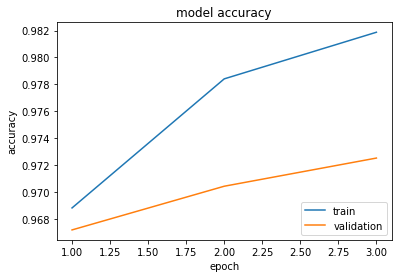

In [108]:
epochs_range = range(1, len(history.history['acc']) + 1)
plt.plot(epochs_range, history.history['acc'])
plt.plot(epochs_range, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='lower right')
plt.show()

#### Loss

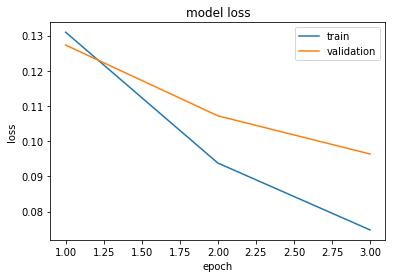

In [109]:
plt.plot(epochs_range, history.history['loss'])
plt.plot(epochs_range, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Test the model

In [110]:
test_generator = DataGenerator(data_test_path, batch_size=batch_size, image_shape=(image_shape, image_shape))
scores = model.evaluate_generator(test_generator.get_generator(), n_test_samples // batch_size)
print()
print('Loss: ' + str(scores[0]))
print('Accuracy: ' + str(scores[1]))

Found 12630 images belonging to 43 classes.
63/63 [==============================] - 15s 238ms/step

Loss: 0.699734859523319
Accuracy: 0.8938888822283063


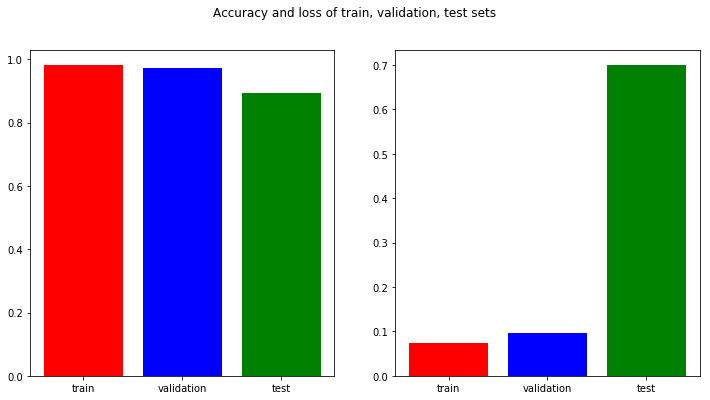

In [107]:
accuracy = np.array([
    history.history['acc'][-1],
    history.history['val_acc'][-1],
    scores[1]
])

loss = np.array([
    history.history['loss'][-1],
    history.history['val_loss'][-1],
    scores[0]
])

names = ['train', 'validation', 'test']
color = 'rbg'

plt.figure(1, figsize=(12, 6))

plt.subplot(121)
plt.bar(names, accuracy, color=color)
plt.subplot(122)
plt.bar(names, loss, color=color)
plt.suptitle('Accuracy and loss of train, validation, test sets')
plt.show()